Key points of an Input Image, Descriptors of an Input Image 5491 5491
Key points of Human Template, Descriptors of Human Template 800 800
[0 1 2 3 4 5 6]
number of estimated clusters : 7
Not enough matches are found - 7/10
Not enough matches are found - 5/10
Not enough matches are found - 9/10


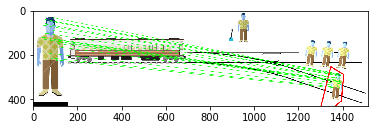

Not enough matches are found - 5/10


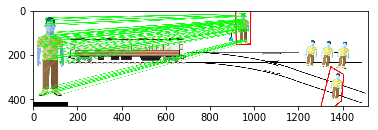

Not enough matches are found - 5/10


In [3]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

#np.version.version

MIN_MATCH_COUNT = 10 #atleast 15 matches (defined by MIN_MATCH_COUNT) are to be there to find the object. 

img1 = cv2.imread('hum.jpg') # read the query Image
img2 = cv2.imread('trolley.jpg') # read the train Image

#orb = cv2.ORB_create(nfeatures=20000, scaleFactor=1.2, nlevels=8, edgeThreshold = 5, scoreType=cv2.ORB_FAST_SCORE)

orb = cv2.ORB_create(20000, 1.2, nlevels=8, edgeThreshold = 5) #20000, 5. Create ORB

# cv.ORB_create([, nfeatures[, scaleFactor[, nlevels[, edgeThreshold[, firstLevel[, WTA_K[, scoreType[, patchSize[, fastThreshold]]]]]]]]])

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1, None) #creates keypoints and descriptors
kp2, des2 = orb.detectAndCompute(img2, None) #creates keypoints and descriptors

print("Key points of an Input Image, Descriptors of an Input Image", len(kp2), len(des2))
print("Key points of Human Template, Descriptors of Human Template", len(kp1), len(des1))

img1Point = cv2.drawKeypoints(img1,kp2,None,(255,0,0),4)

cv2.imwrite(r'Human Template Key Point.jpg', img1Point)


from sklearn.cluster import MeanShift, estimate_bandwidth

x = np.array([kp2[0].pt])

for i in range(len(kp2)):
    x = np.append(x, [kp2[i].pt], axis=0)

x = x[1:len(x)]

bandwidth = estimate_bandwidth(x, quantile=0.1, n_samples=500) #500

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=True)
ms.fit(x)
labels = ms.labels_

#print(labels)
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)

print(labels_unique)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

s = [None] * n_clusters_
for i in range(n_clusters_):
    l = ms.labels_
    d, = np.where(l == i)
    #print(d.__len__())
    s[i] = list(kp2[xx] for xx in d)

des2_ = des2

for i in range(n_clusters_):

    kp2 = s[i]
    l = ms.labels_
    d, = np.where(l == i)
    des2 = des2_[d, ]
    
    FLANN_INDEX_LINEAR = 0
    #FLANN_INDEX_KDTREE = 1
    #FLANN_INDEX_KMEANS = 2
    #FLANN_INDEX_COMPOSITE = 3
    #FLANN_INDEX_KDTREE_SINGLE = 4
    ##FLANN_INDEX_HIERARCHICAL = 5
    #@FLANN_INDEX_LSH = 6
    #FLANN_INDEX_SAVED = 254
    #FLANN_INDEX_AUTOTUNED = 255

    index_params = dict(algorithm = FLANN_INDEX_LINEAR, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    des1 = np.float32(des1)
    des2 = np.float32(des2)
    
    #bf = cv2.BFMatcher()
    #matches = bf.knnMatch(des2,des1, k=2)
    #print(matches)


    matches = flann.knnMatch(des1, des2, 2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)
            
            
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5)

        if M is None:
            print ("No Homography")
        else:
            matchesMask = mask.ravel().tolist()

            h,w,c = img1.shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
            dst = cv2.perspectiveTransform(pts,M)

            img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
            
            #print(np.int32(dst))
            
            #we draw our inliers (if successfully found the object) or matching keypoints (if failed)

            draw_params = dict(matchColor=(0, 255, 0),  # draw matches in green color
                               singlePointColor=None,
                               matchesMask=matchesMask,  # draw only inliers
                               flags=2)

            img3 = cv2.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params)

            plt.imshow(img3, 'gray'), plt.show()

    else:
        print ("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
        matchesMask = None